In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
sys.path.append('../')

try:
    from premier_league import (
        constants,
        preprocessing,
        preprocessing_helpers,
        training,
        evaluation,
        prediction,
        data_extraction,
        visualisations,
        s3_helpers,
        postgres,
        mlflow_functions,
        expectations_helpers,
        email_functions,
        data_drift_functions,
    )
except ModuleNotFoundError:
    import constants
    import preprocessing
    import preprocessing_helpers
    import training
    import evaluation
    import prediction
    import data_extraction
    import visualisations
    import s3_helpers
    import postgres
    import mlflow_functions
    import expectations_helpers
    import email_functions
    import data_drift_functions

2023-11-28 07:42:20,591 - PremierLeagueLogger - INFO - Grabbing Passwords


In [2]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]

2023-11-28 07:42:26,596 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-28 07:42:29,352 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [3]:
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


### Set up data validation

In [4]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_class = expectations_helpers.AutoGreatExpectations(df)

In [5]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_data = ge_class.generate_expectations(verbose=False)

Generating expectations
Done


In [6]:
if constants.RUN_DATA_EXPECTATIONS:
    expectations_helpers.view_suite_summary(ge_data)

2023-11-28 07:42:30,534 - PremierLeagueLogger - INFO - Total Expectations: 18
2023-11-28 07:42:31,734 - PremierLeagueLogger - INFO - Counts:
2023-11-28 07:42:32,826 - PremierLeagueLogger - INFO - expect_column_values_to_be_of_type: 7
2023-11-28 07:42:33,956 - PremierLeagueLogger - INFO - expect_column_values_to_be_of_type: 7
2023-11-28 07:42:35,051 - PremierLeagueLogger - INFO - expect_column_values_to_be_null: 7
2023-11-28 07:42:36,215 - PremierLeagueLogger - INFO - expect_column_values_to_be_null: 7
2023-11-28 07:42:37,301 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1
2023-11-28 07:42:38,410 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1
2023-11-28 07:42:39,494 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2
2023-11-28 07:42:40,599 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2
2023-11-28 07:42:41,696 - PremierLeagueLogger - INFO - expect_table_columns_to_match_set: 1
2023-11-28 07:42:42,785 - Premi

In [7]:
# Save expectations to S3
expectations_helpers.save_expectations(
    ge_data,
    f'app_data/expectations/exp_prem_results_{constants.current_time}.json'
)

2023-11-28 07:42:43,926 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/exp_prem_results_20231128.json
2023-11-28 07:42:45,984 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/exp_prem_results_20231128.json


### Validate data

In [8]:
# Load latest expectations
data_expectations = expectations_helpers.load_latest_expectations(
    expectations_helpers.latest_exp_file()
)

2023-11-28 07:42:47,978 - PremierLeagueLogger - INFO - Looking for latest expectations file
2023-11-28 07:42:49,179 - PremierLeagueLogger - INFO - Loading expectations from premier-league-app/app_data/expectations/exp_prem_results_20231128.json
2023-11-28 07:42:51,042 - PremierLeagueLogger - INFO - Loaded expectations from premier-league-app/app_data/expectations/exp_prem_results_20231128.json


In [9]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION
    )


2023-11-28 07:42:52,227 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-28 07:42:54,750 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [10]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

2023-11-28 07:42:55,853 - PremierLeagueLogger - INFO - Trying to read data from https://www.football-data.co.uk/mmz4281/2324/E0.csv
2023-11-28 07:42:58,119 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/training_data_full.csv
2023-11-28 07:43:01,182 - PremierLeagueLogger - INFO - Data saved at app_data/training_data_full.csv


In [11]:
validation_results = expectations_helpers.validate_data(
        full_data, 
        data_expectations,
        expectations_path = constants.VALIDATION_RESULTS_PATH
)

2023-11-28 07:43:02,353 - PremierLeagueLogger - INFO - {'evaluated_expectations': 18, 'successful_expectations': 18, 'unsuccessful_expectations': 0, 'success_percent': 100.0}
2023-11-28 07:43:03,477 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/valid_results_20231128.json
2023-11-28 07:43:05,549 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/valid_results_20231128.json


In [12]:
if not validation_results['success']:
    email_functions.send_email(
        'data_validation',
        constants.S3_BUCKET, 
        expectations_helpers.latest_exp_file(),
        constants.VALIDATION_TOPIC, 
    )
    raise Exception('Stopping Pipeline. Validation has failed')

### Data Drift Detection

In [13]:
# Load historical data
historical = s3_helpers.grab_data_s3(
    constants.HISTORICAL_DATA_DRIFT
)

2023-11-28 07:43:06,749 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/historical_pl_data.csv
2023-11-28 07:43:09,377 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/historical_pl_data.csv


In [14]:
data_drift = data_drift_functions.DriftDetector(
    historical,
    full_data
)

In [15]:
drift_report = data_drift.check_data_drift(
    constants.DRIFT_REPORT_LOC
)

2023-11-28 07:43:11,069 - PremierLeagueLogger - INFO - Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231128.html
INFO:PremierLeagueLogger:Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231128.html
2023-11-28 07:43:15,352 - PremierLeagueLogger - INFO - Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231128.html
INFO:PremierLeagueLogger:Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231128.html


{'drift_share': 0.5, 'number_of_columns': 7, 'number_of_drifted_columns': 0, 'share_of_drifted_columns': 0.0, 'dataset_drift': False}


### Preprocessing

In [16]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]
df.head()

2023-11-28 07:43:16,740 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-28 07:43:19,279 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Successfully loaded data from premier-league-app/app_data/training_data_full.csv


,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


In [17]:
transformers = preprocessing.fit_transformers(
    df
)

2023-11-28 07:43:20,409 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer
2023-11-28 07:43:21,514 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer


In [18]:
s3_helpers.save_transformer_s3_pickle(
    transformers, 
    constants.TRANSFORMER_PATH
)

2023-11-28 07:43:44,971 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231128.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231128.pkl
2023-11-28 07:43:47,125 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231128.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231128.pkl


In [19]:
transformed_data = preprocessing.transform_data(
    df, transformers
)

2023-11-28 07:43:48,247 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data
2023-11-28 07:43:49,351 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data


In [20]:
#transformed_data = transformed_data.drop(['HomeTeam', 'AwayTeam', 'season'], axis=1)

In [21]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-11-28 07:44:12,443 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [22]:
training_data.shape

(8616, 33)

In [23]:
testing_data.shape

(2154, 33)

In [24]:
training_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate
0,1995-96,Everton,Wimbledon,2,46.0,42.0,32.0,61.0,1.516129,0.870968,...,0.451613,-0.612903,0.645161,0.225806,8,14,-6,Saturday,March,23
1,2012-13,West Brom,Newcastle,1,43.0,42.0,44.0,59.0,1.323529,1.058824,...,-0.029412,-0.500000,0.264706,-0.029412,7,11,-4,Saturday,April,20


### Model Training

In [25]:
target_column = 'FTR'

In [26]:
hyperparameters = training.optimise_hyperparameters(
    training_data,
    target_column,
    max_evals = constants.MAX_EVALS
)

2023-11-28 07:44:13,752 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-28 07:44:14,786 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                     | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-28 07:44:15,895 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:17,128 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:19,737 - PremierLeagueLogger - INFO - Loss: -0.5307424593967517
INFO:PremierLeagueLogger:Loss: -0.5307424593967517


  5%|██▉                                                       | 1/20 [00:04<01:33,  4.92s/trial, best loss: -0.5307424593967517]

2023-11-28 07:44:20,824 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:21,868 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:24,484 - PremierLeagueLogger - INFO - Loss: -0.5226218097447796
INFO:PremierLeagueLogger:Loss: -0.5226218097447796


 10%|█████▊                                                    | 2/20 [00:09<01:26,  4.80s/trial, best loss: -0.5307424593967517]

2023-11-28 07:44:25,534 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:26,598 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:28,477 - PremierLeagueLogger - INFO - Loss: -0.5342227378190255
INFO:PremierLeagueLogger:Loss: -0.5342227378190255


 15%|████████▋                                                 | 3/20 [00:13<01:16,  4.51s/trial, best loss: -0.5342227378190255]

2023-11-28 07:44:29,707 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:30,775 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:32,978 - PremierLeagueLogger - INFO - Loss: -0.5301624129930395
INFO:PremierLeagueLogger:Loss: -0.5301624129930395


 20%|███████████▌                                              | 4/20 [00:18<01:11,  4.45s/trial, best loss: -0.5342227378190255]

2023-11-28 07:44:34,061 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:35,115 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:37,230 - PremierLeagueLogger - INFO - Loss: -0.5301624129930395
INFO:PremierLeagueLogger:Loss: -0.5301624129930395


 25%|██████████████▌                                           | 5/20 [00:22<01:05,  4.36s/trial, best loss: -0.5342227378190255]

2023-11-28 07:44:38,413 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:39,396 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:40,962 - PremierLeagueLogger - INFO - Loss: -0.5284222737819025
INFO:PremierLeagueLogger:Loss: -0.5284222737819025


 30%|█████████████████▍                                        | 6/20 [00:26<00:57,  4.13s/trial, best loss: -0.5342227378190255]

2023-11-28 07:44:41,948 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:42,926 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:45,026 - PremierLeagueLogger - INFO - Loss: -0.5301624129930395
INFO:PremierLeagueLogger:Loss: -0.5301624129930395


 35%|████████████████████▎                                     | 7/20 [00:30<00:53,  4.11s/trial, best loss: -0.5342227378190255]

2023-11-28 07:44:46,011 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:47,009 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:48,726 - PremierLeagueLogger - INFO - Loss: -0.5220417633410673
INFO:PremierLeagueLogger:Loss: -0.5220417633410673


 40%|███████████████████████▏                                  | 8/20 [00:33<00:47,  3.98s/trial, best loss: -0.5342227378190255]

2023-11-28 07:44:49,729 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:50,720 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:44:56,076 - PremierLeagueLogger - INFO - Loss: -0.5353828306264501
INFO:PremierLeagueLogger:Loss: -0.5353828306264501


 45%|██████████████████████████                                | 9/20 [00:41<00:55,  5.03s/trial, best loss: -0.5353828306264501]

2023-11-28 07:44:57,062 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:44:58,071 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:00,250 - PremierLeagueLogger - INFO - Loss: -0.5284222737819025
INFO:PremierLeagueLogger:Loss: -0.5284222737819025


 50%|████████████████████████████▌                            | 10/20 [00:45<00:47,  4.79s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:01,315 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:02,381 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:05,120 - PremierLeagueLogger - INFO - Loss: -0.5220417633410673
INFO:PremierLeagueLogger:Loss: -0.5220417633410673


 55%|███████████████████████████████▎                         | 11/20 [00:50<00:43,  4.82s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:06,195 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:07,263 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:09,414 - PremierLeagueLogger - INFO - Loss: -0.527262180974478
INFO:PremierLeagueLogger:Loss: -0.527262180974478


 60%|██████████████████████████████████▏                      | 12/20 [00:54<00:37,  4.66s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:10,483 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:11,556 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:17,411 - PremierLeagueLogger - INFO - Loss: -0.5307424593967517
INFO:PremierLeagueLogger:Loss: -0.5307424593967517


 65%|█████████████████████████████████████                    | 13/20 [01:02<00:40,  5.73s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:18,690 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:19,748 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:21,760 - PremierLeagueLogger - INFO - Loss: -0.5237819025522041
INFO:PremierLeagueLogger:Loss: -0.5237819025522041


 70%|███████████████████████████████████████▉                 | 14/20 [01:06<00:31,  5.25s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:22,836 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:23,905 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:25,229 - PremierLeagueLogger - INFO - Loss: -0.5203016241299304
INFO:PremierLeagueLogger:Loss: -0.5203016241299304


 75%|██████████████████████████████████████████▊              | 15/20 [01:10<00:23,  4.71s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:26,286 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:27,404 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:29,339 - PremierLeagueLogger - INFO - Loss: -0.5330626450116009
INFO:PremierLeagueLogger:Loss: -0.5330626450116009


 80%|█████████████████████████████████████████████▌           | 16/20 [01:14<00:18,  4.54s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:30,426 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:31,501 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:34,127 - PremierLeagueLogger - INFO - Loss: -0.5226218097447796
INFO:PremierLeagueLogger:Loss: -0.5226218097447796


 85%|████████████████████████████████████████████████▍        | 17/20 [01:19<00:13,  4.67s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:35,392 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:36,487 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:40,351 - PremierLeagueLogger - INFO - Loss: -0.5278422273781903
INFO:PremierLeagueLogger:Loss: -0.5278422273781903


 90%|███████████████████████████████████████████████████▎     | 18/20 [01:25<00:10,  5.08s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:41,437 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:42,511 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:45,969 - PremierLeagueLogger - INFO - Loss: -0.525522041763341
INFO:PremierLeagueLogger:Loss: -0.525522041763341


 95%|██████████████████████████████████████████████████████▏  | 19/20 [01:31<00:05,  5.24s/trial, best loss: -0.5353828306264501]

2023-11-28 07:45:47,060 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:45:48,141 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:45:50,002 - PremierLeagueLogger - INFO - Loss: -0.5243619489559165
INFO:PremierLeagueLogger:Loss: -0.5243619489559165


100%|█████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.77s/trial, best loss: -0.5353828306264501]


In [27]:
print(hyperparameters)

{'learning_rate': 0.020000000000000004, 'iterations': 300, 'max_depth': 6}


In [28]:
# Start postgresDB for model logging
if postgres.get_instance_status(
        constants.POSTGRES_DB_ID) != 'available':
    postgres.start_rds_instance(constants.POSTGRES_DB_ID)

2023-11-28 07:45:51,305 - PremierLeagueLogger - INFO - Grabbing instance status of premier-league-logging
INFO:PremierLeagueLogger:Grabbing instance status of premier-league-logging
2023-11-28 07:45:54,438 - PremierLeagueLogger - INFO - Starting RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Starting RDS instance 'premier-league-logging'
2023-11-28 07:45:56,374 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-11-28 07:47:58,677 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-11-28 07:50:01,112 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-11-28 07:52:03,882 - PremierLeagueLogger - INFO - RDS instance status

In [29]:
# Open mlflow tracking
mlflow_functions.open_mlflow_tracking(
    constants.EXP_NAME
)

In [30]:
classifier, run_id = training.train_model(
    training_data[[col for col in training_data if col != target_column]],
    training_data[target_column],
    hyperparameters = hyperparameters
)

2023-11-28 07:54:15,517 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-28 07:54:24,413 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [31]:
s3_helpers.save_transformer_s3_pickle(
    classifier, 
    constants.CLASS_MODEL_NAME,
    is_transformer=False
)

2023-11-28 07:54:37,320 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/classifier_v2_20231128.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/classifier_v2_20231128.pkl
2023-11-28 07:54:40,294 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/classifier_v2_20231128.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/classifier_v2_20231128.pkl


### Prediction

In [32]:
y_test = testing_data[target_column]
x_test = testing_data[[col for col in testing_data if col != target_column]]

In [33]:
predictions = prediction.predict(x_test, classifier)

2023-11-28 07:54:41,556 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


### Evaluation

In [34]:
evaluation_metrics = evaluation.evaluate_model(
    predictions, 
    y_test,
    model_type='result',
    run_id=run_id
)

2023-11-28 07:54:42,650 - PremierLeagueLogger - INFO - Evaluating result model
INFO:PremierLeagueLogger:Evaluating result model
2023-11-28 07:54:47,861 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


In [35]:
evaluation_metrics

{'mcc': 0.23399496095534708,
 'accuracy': 0.5301764159702879,
 'f1': 0.46215419805928687,
 'confusion_matrix': [[828, 20, 147], [386, 24, 148], [294, 17, 290]]}

### Part 2: Predict Score

In [36]:
transformed_data = prediction.add_match_result(
    transformed_data, classifier, df )

2023-11-28 07:54:53,416 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [37]:
s3_helpers.save_data_s3(
    transformed_data,
    constants.TRANSFORMED_DATA_LOCATION
)

2023-11-28 07:54:54,560 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/transformed_data_cc.csv
INFO:PremierLeagueLogger:Savng data to premier-league-app/app_data/transformed_data_cc.csv


In [38]:
transformed_data.shape

(10770, 36)

In [39]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-11-28 07:54:57,709 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [40]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR','FTAG'], axis=1),
    'FTHG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-11-28 07:54:58,775 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-28 07:54:59,808 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                     | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-28 07:55:00,874 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:02,010 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:06,359 - PremierLeagueLogger - INFO - Loss: 1.5829480751063139
INFO:PremierLeagueLogger:Loss: 1.5829480751063139


  5%|██▉                                                        | 1/20 [00:06<02:04,  6.54s/trial, best loss: 1.5829480751063139]

2023-11-28 07:55:07,421 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:08,437 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:12,206 - PremierLeagueLogger - INFO - Loss: 1.58066915171389
INFO:PremierLeagueLogger:Loss: 1.58066915171389


 10%|██████                                                       | 2/20 [00:12<01:52,  6.23s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:13,430 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:14,559 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:16,059 - PremierLeagueLogger - INFO - Loss: 1.5910243380622269
INFO:PremierLeagueLogger:Loss: 1.5910243380622269


 15%|█████████▏                                                   | 3/20 [00:16<01:25,  5.05s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:17,077 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:18,089 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:19,252 - PremierLeagueLogger - INFO - Loss: 1.582991265214637
INFO:PremierLeagueLogger:Loss: 1.582991265214637


 20%|████████████▏                                                | 4/20 [00:19<01:09,  4.32s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:20,269 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:21,297 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:23,040 - PremierLeagueLogger - INFO - Loss: 1.5849112093331255
INFO:PremierLeagueLogger:Loss: 1.5849112093331255


 25%|███████████████▎                                             | 5/20 [00:23<01:01,  4.11s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:24,022 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:25,315 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:26,485 - PremierLeagueLogger - INFO - Loss: 1.5911837669164501
INFO:PremierLeagueLogger:Loss: 1.5911837669164501


 30%|██████████████████▎                                          | 6/20 [00:26<00:54,  3.90s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:27,502 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:28,687 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:30,022 - PremierLeagueLogger - INFO - Loss: 1.5984835132353636
INFO:PremierLeagueLogger:Loss: 1.5984835132353636


 35%|█████████████████████▎                                       | 7/20 [00:30<00:49,  3.78s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:31,047 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:32,110 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:33,611 - PremierLeagueLogger - INFO - Loss: 1.5881204410969265
INFO:PremierLeagueLogger:Loss: 1.5881204410969265


 40%|████████████████████████▍                                    | 8/20 [00:33<00:44,  3.75s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:34,714 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:35,802 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:37,049 - PremierLeagueLogger - INFO - Loss: 1.5896286477452313
INFO:PremierLeagueLogger:Loss: 1.5896286477452313


 45%|███████████████████████████▍                                 | 9/20 [00:37<00:40,  3.64s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:38,130 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:39,212 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:40,435 - PremierLeagueLogger - INFO - Loss: 1.5911837669164501
INFO:PremierLeagueLogger:Loss: 1.5911837669164501


 50%|██████████████████████████████                              | 10/20 [00:40<00:35,  3.56s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:41,516 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:42,571 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:43,964 - PremierLeagueLogger - INFO - Loss: 1.5844988572509917
INFO:PremierLeagueLogger:Loss: 1.5844988572509917


 55%|█████████████████████████████████                           | 11/20 [00:44<00:32,  3.56s/trial, best loss: 1.58066915171389]

2023-11-28 07:55:45,059 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:46,146 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:47,536 - PremierLeagueLogger - INFO - Loss: 1.5787822368118591
INFO:PremierLeagueLogger:Loss: 1.5787822368118591


 60%|██████████████████████████████████▊                       | 12/20 [00:47<00:28,  3.56s/trial, best loss: 1.5787822368118591]

2023-11-28 07:55:48,637 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:49,735 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:51,276 - PremierLeagueLogger - INFO - Loss: 1.5821156008614905
INFO:PremierLeagueLogger:Loss: 1.5821156008614905


 65%|█████████████████████████████████████▋                    | 13/20 [00:51<00:25,  3.62s/trial, best loss: 1.5787822368118591]

2023-11-28 07:55:52,376 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:53,454 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:55,026 - PremierLeagueLogger - INFO - Loss: 1.6365623618447522
INFO:PremierLeagueLogger:Loss: 1.6365623618447522


 70%|████████████████████████████████████████▌                 | 14/20 [00:55<00:21,  3.65s/trial, best loss: 1.5787822368118591]

2023-11-28 07:55:56,121 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:55:57,199 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:55:58,413 - PremierLeagueLogger - INFO - Loss: 1.589202369307106
INFO:PremierLeagueLogger:Loss: 1.589202369307106


 75%|███████████████████████████████████████████▌              | 15/20 [00:58<00:17,  3.57s/trial, best loss: 1.5787822368118591]

2023-11-28 07:55:59,504 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:00,582 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:01,853 - PremierLeagueLogger - INFO - Loss: 1.5898736862444438
INFO:PremierLeagueLogger:Loss: 1.5898736862444438


 80%|██████████████████████████████████████████████▍           | 16/20 [01:02<00:14,  3.53s/trial, best loss: 1.5787822368118591]

2023-11-28 07:56:02,936 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:04,026 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:05,315 - PremierLeagueLogger - INFO - Loss: 1.5840508492361047
INFO:PremierLeagueLogger:Loss: 1.5840508492361047


 85%|█████████████████████████████████████████████████▎        | 17/20 [01:05<00:10,  3.57s/trial, best loss: 1.5787822368118591]

2023-11-28 07:56:06,582 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:07,677 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:09,469 - PremierLeagueLogger - INFO - Loss: 1.5887831100023988
INFO:PremierLeagueLogger:Loss: 1.5887831100023988


 90%|████████████████████████████████████████████████████▏     | 18/20 [01:09<00:07,  3.69s/trial, best loss: 1.5787822368118591]

2023-11-28 07:56:10,573 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:11,678 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:16,107 - PremierLeagueLogger - INFO - Loss: 1.592747624971834
INFO:PremierLeagueLogger:Loss: 1.592747624971834


 95%|███████████████████████████████████████████████████████   | 19/20 [01:16<00:04,  4.57s/trial, best loss: 1.5787822368118591]

2023-11-28 07:56:17,208 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:18,282 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:19,483 - PremierLeagueLogger - INFO - Loss: 1.5911837669164501
INFO:PremierLeagueLogger:Loss: 1.5911837669164501


100%|██████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.99s/trial, best loss: 1.5787822368118591]


In [41]:
regressor_1, run_id_home = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTHG'],
    model_type='home',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-11-28 07:56:20,591 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-28 07:56:24,296 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [42]:
s3_helpers.save_transformer_s3_pickle(
    regressor_1, 
    constants.HOME_MODEL_NAME,
    is_transformer=False
)

2023-11-28 07:56:35,392 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231128.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231128.pkl
2023-11-28 07:56:38,492 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231128.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231128.pkl


In [43]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR', 'FTHG'], axis=1),
    'FTAG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-11-28 07:56:39,773 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-28 07:56:41,022 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                     | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-28 07:56:42,269 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:43,567 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:44,960 - PremierLeagueLogger - INFO - Loss: 1.1612387910848223
INFO:PremierLeagueLogger:Loss: 1.1612387910848223


  5%|██▉                                                        | 1/20 [00:03<01:14,  3.93s/trial, best loss: 1.1612387910848223]

2023-11-28 07:56:46,208 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:47,452 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:49,152 - PremierLeagueLogger - INFO - Loss: 1.1538165740681672
INFO:PremierLeagueLogger:Loss: 1.1538165740681672


 10%|█████▉                                                     | 2/20 [00:08<01:13,  4.08s/trial, best loss: 1.1538165740681672]

2023-11-28 07:56:50,398 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:51,852 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:53,823 - PremierLeagueLogger - INFO - Loss: 1.147835182050997
INFO:PremierLeagueLogger:Loss: 1.147835182050997


 15%|█████████                                                   | 3/20 [00:12<01:14,  4.36s/trial, best loss: 1.147835182050997]

2023-11-28 07:56:55,091 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:56:56,352 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:56:58,750 - PremierLeagueLogger - INFO - Loss: 1.1558055575491966
INFO:PremierLeagueLogger:Loss: 1.1558055575491966


 20%|████████████                                                | 4/20 [00:17<01:13,  4.58s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:00,001 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:01,247 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:03,092 - PremierLeagueLogger - INFO - Loss: 1.1551588953884293
INFO:PremierLeagueLogger:Loss: 1.1551588953884293


 25%|███████████████                                             | 5/20 [00:22<01:07,  4.50s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:04,353 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:05,626 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:07,440 - PremierLeagueLogger - INFO - Loss: 1.1573322532807773
INFO:PremierLeagueLogger:Loss: 1.1573322532807773


 30%|██████████████████                                          | 6/20 [00:26<01:02,  4.44s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:08,690 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:09,941 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:11,413 - PremierLeagueLogger - INFO - Loss: 1.1573030547979724
INFO:PremierLeagueLogger:Loss: 1.1573030547979724


 35%|█████████████████████                                       | 7/20 [00:30<00:55,  4.28s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:12,637 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:13,893 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:15,421 - PremierLeagueLogger - INFO - Loss: 1.1592039805239085
INFO:PremierLeagueLogger:Loss: 1.1592039805239085


 40%|████████████████████████                                    | 8/20 [00:34<00:50,  4.19s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:16,648 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:17,891 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:19,248 - PremierLeagueLogger - INFO - Loss: 1.1562834971608569
INFO:PremierLeagueLogger:Loss: 1.1562834971608569


 45%|███████████████████████████                                 | 9/20 [00:38<00:44,  4.09s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:20,496 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:21,726 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:25,145 - PremierLeagueLogger - INFO - Loss: 1.1555773535535037
INFO:PremierLeagueLogger:Loss: 1.1555773535535037


 50%|█████████████████████████████▌                             | 10/20 [00:44<00:46,  4.65s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:26,393 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:27,630 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:29,165 - PremierLeagueLogger - INFO - Loss: 1.1511927223595049
INFO:PremierLeagueLogger:Loss: 1.1511927223595049


 55%|████████████████████████████████▍                          | 11/20 [00:48<00:40,  4.45s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:30,395 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:31,653 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:33,129 - PremierLeagueLogger - INFO - Loss: 1.154382043516793
INFO:PremierLeagueLogger:Loss: 1.154382043516793


 60%|███████████████████████████████████▍                       | 12/20 [00:52<00:34,  4.31s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:34,389 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:35,628 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:37,112 - PremierLeagueLogger - INFO - Loss: 1.1501339607750927
INFO:PremierLeagueLogger:Loss: 1.1501339607750927


 65%|██████████████████████████████████████▎                    | 13/20 [00:56<00:29,  4.21s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:38,367 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:39,622 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:41,161 - PremierLeagueLogger - INFO - Loss: 1.1538147242145362
INFO:PremierLeagueLogger:Loss: 1.1538147242145362


 70%|█████████████████████████████████████████▎                 | 14/20 [01:00<00:24,  4.16s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:42,428 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:43,709 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:45,554 - PremierLeagueLogger - INFO - Loss: 1.1534588068189302
INFO:PremierLeagueLogger:Loss: 1.1534588068189302


 75%|████████████████████████████████████████████▎              | 15/20 [01:04<00:21,  4.23s/trial, best loss: 1.147835182050997]

2023-11-28 07:57:46,796 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:48,039 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:49,727 - PremierLeagueLogger - INFO - Loss: 1.1475788067743524
INFO:PremierLeagueLogger:Loss: 1.1475788067743524


 80%|██████████████████████████████████████████████▍           | 16/20 [01:08<00:16,  4.22s/trial, best loss: 1.1475788067743524]

2023-11-28 07:57:51,005 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:52,441 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:54,805 - PremierLeagueLogger - INFO - Loss: 1.1516065444449273
INFO:PremierLeagueLogger:Loss: 1.1516065444449273


 85%|█████████████████████████████████████████████████▎        | 17/20 [01:13<00:13,  4.47s/trial, best loss: 1.1475788067743524]

2023-11-28 07:57:56,063 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:57:57,313 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:57:58,701 - PremierLeagueLogger - INFO - Loss: 1.1575304467282814
INFO:PremierLeagueLogger:Loss: 1.1575304467282814


 90%|████████████████████████████████████████████████████▏     | 18/20 [01:17<00:08,  4.32s/trial, best loss: 1.1475788067743524]

2023-11-28 07:58:00,021 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:58:01,283 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:58:02,766 - PremierLeagueLogger - INFO - Loss: 1.1563255122272607
INFO:PremierLeagueLogger:Loss: 1.1563255122272607


 95%|███████████████████████████████████████████████████████   | 19/20 [01:21<00:04,  4.23s/trial, best loss: 1.1475788067743524]

2023-11-28 07:58:04,031 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-28 07:58:05,311 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-28 07:58:06,749 - PremierLeagueLogger - INFO - Loss: 1.1609786679644245
INFO:PremierLeagueLogger:Loss: 1.1609786679644245


100%|██████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.30s/trial, best loss: 1.1475788067743524]


In [44]:
regressor_2, run_id_away = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTAG'],
    model_type='away',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-11-28 07:58:08,327 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-28 07:58:13,717 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [45]:
s3_helpers.save_transformer_s3_pickle(
    regressor_2, 
    constants.AWAY_MODEL_NAME,
    is_transformer=False
)

2023-11-28 07:58:25,045 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231128.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231128.pkl
2023-11-28 07:58:28,652 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231128.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231128.pkl


### Predict Home Goals

In [46]:
y_test = testing_data['FTHG']
x_test = testing_data.copy()

In [47]:
predictions_1 = prediction.predict(x_test, regressor_1)

2023-11-28 07:58:29,948 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [48]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_1, 
    y_test, 
    model_type='home',
    run_id=run_id_home    
)
evaluation_metrics

2023-11-28 07:58:31,241 - PremierLeagueLogger - INFO - Evaluating home model
INFO:PremierLeagueLogger:Evaluating home model
2023-11-28 07:58:36,669 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': 0.03500474001018028,
 'median_ae': 1.0,
 'mean_ae': 0.9363974001857011}

### Predict Away Goals

In [49]:
y_test = testing_data['FTAG']
x_test = testing_data.copy()

In [50]:
predictions_2 = prediction.predict(
    x_test, classifier)

2023-11-28 07:58:42,621 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [51]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_2, 
    y_test, 
    model_type='away',
    run_id=run_id_away
)
evaluation_metrics

2023-11-28 07:58:44,086 - PremierLeagueLogger - INFO - Evaluating away model
INFO:PremierLeagueLogger:Evaluating away model
2023-11-28 07:58:49,607 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': -0.5125000892226212,
 'median_ae': 1.0,
 'mean_ae': 0.9670380687093779}

In [52]:
# Close DB Instance
postgres.stop_rds_instance(
    constants.POSTGRES_DB_ID
)

2023-11-28 07:58:57,780 - PremierLeagueLogger - INFO - Stopping RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Stopping RDS instance 'premier-league-logging'


### Visualisations of results

In [53]:
x_test['Home Prediction'] = predictions_1
x_test['Away Prediction'] = predictions_2

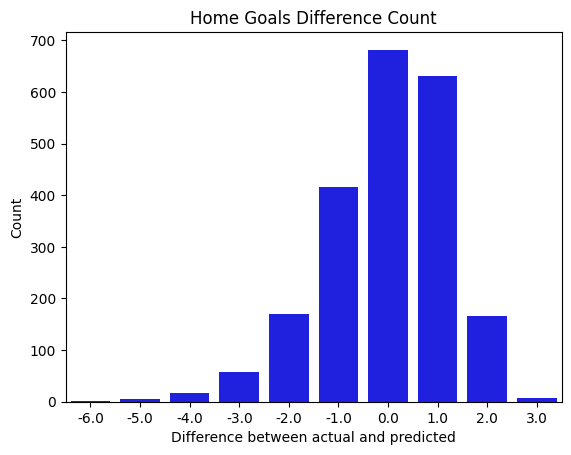

In [54]:
visualisations.histoplot(x_test, ha='Home')

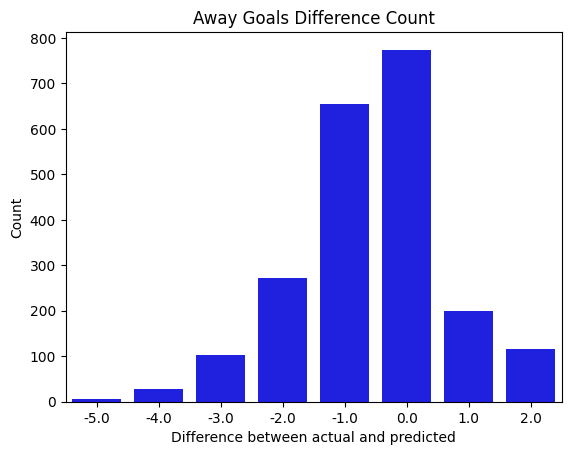

In [55]:
visualisations.histoplot(x_test, ha='Away')

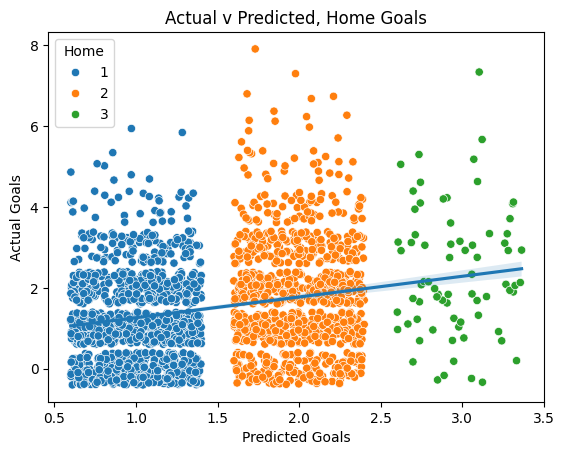

In [56]:
visualisations.actuals_predicted(x_test, ha='Home')

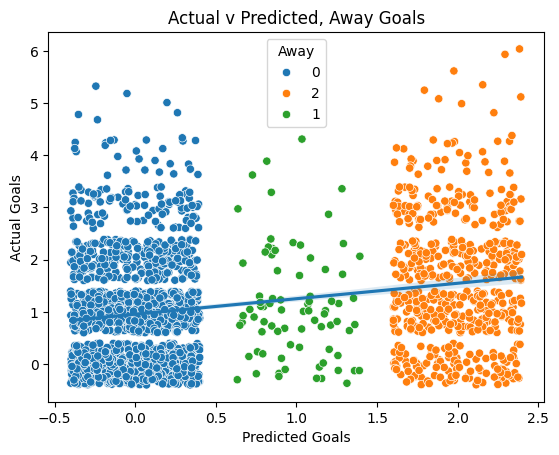

In [57]:
visualisations.actuals_predicted(x_test, ha='Away')

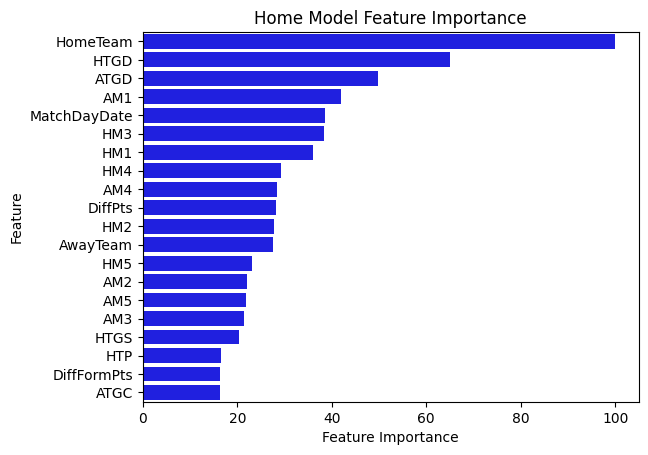

In [58]:
visualisations.plot_features(regressor_1, 'Home',n=20)

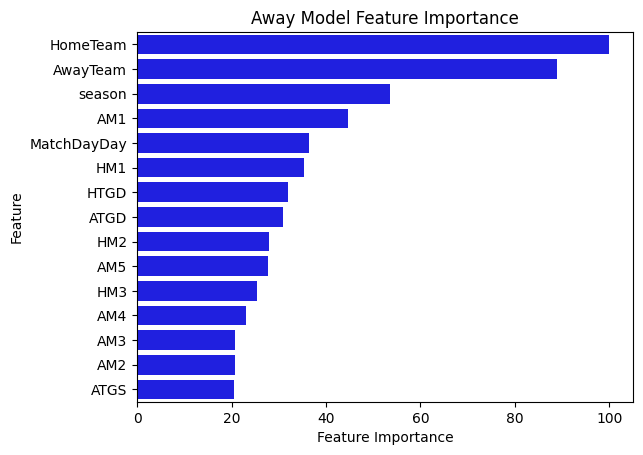

In [59]:
visualisations.plot_features(regressor_2, 'Away')